# Setup

In [ ]:
!pip install pytorch_metric_learning
!pip install faiss-gpu
# !pip install faiss-cpu
!pip install umap-learn

     |████████████████████████████████| 112kB 36.3MB/s 
     |████████████████████████████████| 89.4MB 46kB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 1.2MB 26.8MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=28b000399371e885ec2a974598e3cc12d1316ddfc9ecea4c9f35fad6c516c92a
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=4be54f269632adc4eb609c42239b00fdb20eb7564ba841d4f5518cd001da6151
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
import umap.umap_ as umap
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from sklearn import decomposition
from itertools import permutations
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from pytorch_metric_learning import losses, miners, reducers, samplers, distances
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering



np.set_printoptions(suppress=True)

In [ ]:
drive.mount('/content/gdrive/')
path = 'gdrive/MyDrive/Programming Projects/Embeddings/data/'

Mounted at /content/gdrive/


In [ ]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu") 

In [ ]:
#HYPERPARAMETERS

np.random.seed(1871)
CHECKPOINT_PATH = path + "model.pt"
LOAD_PICKLED_DATASET = True

#Positive pairs generation
SEQUENCE_LEN = 120
SEQUENCES_PER_CLIENT = 10

#Encoder
EVENT_ENCODING_DIMENSIONS = 32
RNN_HIDDEN_STATE_DIMENSIONS = 256
EVENT_EMBEDDING_DIMENSIONS = 8

EPOCHS = 40
BATCH_SIZE = 128
LEARNING_RATE = 5e-4


#CLUSTERING
NUM_OF_CLUSTERS = 4



# Data

In [ ]:
def subsequence_generator(sequence, pad_vector, to_generate=10, length=120):
    start_idx = np.random.randint(0, len(sequence) - 1, size=to_generate)
    ret = np.tile(pad_vector, (to_generate, length, 1))

    for i, idx in enumerate(start_idx):
        subsequence = sequence[idx:]
        ret[i, 0:subsequence.shape[0]] = subsequence[:min(len(subsequence), length)]

    return ret

In [ ]:
class TransactionDataset(Dataset):
    def __init__(self, data, num_subsequences=10, subsequence_len=120):
        self.clients = data['client_id'].unique()
        

        data['small_group'] = data['small_group'] + 1 # allowing us to use "0" as padding

        data['trans_date'] = pd.to_datetime(data['trans_date'], unit='d')
        data['day_of_week'] = data['trans_date'].dt.dayofweek + 1
        data['month'] = data['trans_date'].dt.month
        data = data.drop(columns=['trans_date'])

        data=data.reindex(columns=['client_id','small_group', 'day_of_week', 'month', 'amount_rur'])


        pad_sequence = np.array([0,0,0,0.])

        self.data = list()
        for i, client in enumerate(self.clients):
            sequence = data[data['client_id'] == client].drop(columns=['client_id']).to_numpy()
            self.data.append(subsequence_generator(sequence, pad_sequence, num_subsequences, subsequence_len))
            
        self.data = np.array(self.data)
        

    def __len__(self):
        return self.clients.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.clients[idx]

In [ ]:
df = pd.read_csv(path + "transactions_train.csv")


if LOAD_PICKLED_DATASET:
    train_dataset = pickle.load(open(path + "unsupervised_train_dataset.p", "rb" ))
    test_dataset = pickle.load(open(path + "unsupervised_test_dataset.p", "rb" ))
else:
    test_clients = np.random.choice(df.client_id.unique(), size=int(0.2 * df.client_id.nunique()), replace=False)
    train_clients = np.array(list(set(df.client_id.unique()) - set(test_clients)))
    train_idx = ~df.client_id.isin(test_clients)

    df_train = df[train_idx].copy()
    df_test = df[~train_idx].copy()
    train_dataset = TransactionDataset(df_train, 
                                    num_subsequences=SEQUENCES_PER_CLIENT,
                                    subsequence_len=SEQUENCE_LEN)
    pickle.dump(train_dataset, open(path + "unsupervised_train_dataset.p", "wb" ) )

    test_dataset = TransactionDataset(df_test, 
                                    num_subsequences=SEQUENCES_PER_CLIENT,
                                    subsequence_len=SEQUENCE_LEN)
    pickle.dump(test_dataset, open(path + "unsupervised_test_dataset.p", "wb" ) )


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_sampler = samplers.MPerClassSampler(train_dataset.clients, 1, batch_size=BATCH_SIZE, length_before_new_iter=len(train_dataset))
test_sampler = samplers.MPerClassSampler(test_dataset.clients, 1, batch_size=BATCH_SIZE, length_before_new_iter=len(test_dataset))

print(len(train_dataset), len(test_dataset))

24000 6000


# Encoder


In [ ]:
class EventEncoder(nn.Module):
    def __init__(self, num_features, cat_features, cat_vocab_sizes, out_dim, emb_dim=32):
        super(EventEncoder, self).__init__()

        self.initial_norm = nn.BatchNorm1d(num_features, affine=False)

        # len(nn.ModuleList) is a bit wacky, so we'll store the size just in case
        self.embeddings = nn.ModuleList() 
        self.cat_features = cat_features 
        for i in range(cat_features):
            self.embeddings.append(nn.Embedding(cat_vocab_sizes[i], emb_dim, padding_idx=0))

        cur_size = emb_dim * cat_features + num_features
        self.process = nn.Sequential(
            nn.Linear(cur_size, out_dim),
            nn.Sigmoid(),
            nn.BatchNorm1d(out_dim),
        )

    def forward(self, numerical, categorical):
        concat_input = self.initial_norm(numerical)

        for i in range(self.cat_features):
            embedded_cat = self.embeddings[i](categorical[:,i])
            concat_input = torch.cat((concat_input, embedded_cat), 1)
        out = self.process(concat_input)
        
        return out

In [ ]:
class SequenceEncoder(nn.Module):
    def __init__(self, num_features, cat_features, cat_vocab_sizes, sequence_len, event_dim=128, hidden_size=128, event_emb_dim=32):

        super(SequenceEncoder, self).__init__()

        self.num_features = num_features
        self.cat_features = cat_features
        self.sequence_len = sequence_len
        self.event_dim = event_dim

        self.event_encoder = EventEncoder(num_features, cat_features, cat_vocab_sizes, event_dim, emb_dim=event_emb_dim)

        self.rnn = nn.GRU(event_dim, hidden_size, batch_first=True)

                     
    def forward(self, numerical, categorical):
        # numerical of size (batch_size, num_of_sequences, sequence_len, num_features)
        # categorical of size (batch_size, num_of_sequences, sequence_len, cat_features)

        numerical = numerical.view(-1, self.num_features)
        categorical = categorical.view(-1, self.cat_features)
        
        # receiving batch_size x num_of_sequences x sequence_len x event_dim events
        events = self.event_encoder(numerical, categorical)
        events = events.view(-1, self.sequence_len, self.event_dim)

        #taking the output of the last cell        
        out = self.rnn(events)[0][:,-1,:]
        
        return out

In [ ]:
encoder = SequenceEncoder(num_features=1, 
                          cat_features=3, 
                          cat_vocab_sizes=[df['small_group'].max() + 2, 8, 13], # +1 for padding 
                          sequence_len=SEQUENCE_LEN, 
                          event_dim=EVENT_ENCODING_DIMENSIONS, 
                          hidden_size=RNN_HIDDEN_STATE_DIMENSIONS,
                          event_emb_dim=EVENT_EMBEDDING_DIMENSIONS)

encoder.to(device)

optimizer = torch.optim.AdamW(encoder.parameters(), lr=LEARNING_RATE)

reduce_func = reducers.AvgNonZeroReducer()
distance_func = distances.LpDistance()
loss_func = losses.TripletMarginLoss(margin=0.3, distance = distance_func, reducer = reduce_func)
miner_func = miners.TripletMarginMiner(margin=0.3, distance = distance_func, type_of_triplets="semihard")

categorical_mask = [True, True, True, False]

In [ ]:
train_loss_history = list()
val_loss_history = list()


for epoch in tqdm(range(EPOCHS)):
    cur_losses = list()

    encoder.train()
    for batch_idx, (sequences, labels) in enumerate(train_dataloader):
        
        numerical = sequences[:,:,:,np.logical_not(categorical_mask)].to(device)
        categorical = sequences[:,:,:,categorical_mask].to(device)
        
        labels = np.repeat(labels, SEQUENCES_PER_CLIENT).to(device)

        embeddings = encoder(numerical.float(), categorical.int()).to(device)
        mining = miner_func(embeddings, labels)
        train_loss = loss_func(embeddings, labels, mining)

        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        cur_losses.append(train_loss.item())

    train_loss_history.append(np.mean(cur_losses))

    cur_losses = list()

    encoder.eval()
    for batch_idx, (sequences, labels) in enumerate(test_dataloader):

        numerical = sequences[:,:,:,np.logical_not(categorical_mask)].to(device)
        categorical = sequences[:,:,:,categorical_mask].to(device)

        labels = np.repeat(labels, SEQUENCES_PER_CLIENT).to(device)

        with torch.no_grad():
            embeddings = encoder(numerical.float(), categorical.int()).to(device)
            mining = miner_func(embeddings, labels)
            val_loss = loss_func(embeddings, labels, mining)

            cur_losses.append(val_loss.item())

    val_loss_history.append(np.mean(cur_losses))

    print("\nEpoch {}; Train loss = {}; Val loss = {}".format(epoch+1, train_loss_history[-1], val_loss_history[-1]))

    torch.save({
            'epoch': epoch,
            'model_state_dict': encoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_history[-1],
            }, CHECKPOINT_PATH)

  0%|          | 0/64 [00:00<?, ?it/s]


Epoch 1; Train loss = 0.16762047300630428; Val loss = 0.16326147761750728


  3%|▎         | 2/64 [04:36<2:23:24, 138.78s/it]


Epoch 2; Train loss = 0.15673174193881928; Val loss = 0.1533668282184195


  5%|▍         | 3/64 [06:54<2:20:47, 138.48s/it]


Epoch 3; Train loss = 0.14715363687657296; Val loss = 0.14419951844722667


  6%|▋         | 4/64 [09:10<2:17:36, 137.61s/it]


Epoch 4; Train loss = 0.1420164614757325; Val loss = 0.14060943779793192


  8%|▊         | 5/64 [11:25<2:14:36, 136.89s/it]


Epoch 5; Train loss = 0.14069142089562214; Val loss = 0.1407173180833776


  9%|▉         | 6/64 [13:40<2:11:44, 136.29s/it]


Epoch 6; Train loss = 0.13983270224738628; Val loss = 0.1395146960907794


 11%|█         | 7/64 [15:55<2:09:06, 135.91s/it]


Epoch 7; Train loss = 0.1375944714279885; Val loss = 0.13514045102799194


 12%|█▎        | 8/64 [18:09<2:06:25, 135.46s/it]


Epoch 8; Train loss = 0.13340079863654805; Val loss = 0.1302823192895727


 14%|█▍        | 9/64 [20:23<2:03:41, 134.94s/it]


Epoch 9; Train loss = 0.12964980819440902; Val loss = 0.12778789756145884


 16%|█▌        | 10/64 [22:36<2:00:53, 134.33s/it]


Epoch 10; Train loss = 0.12853064562412017; Val loss = 0.12764005553215108


 17%|█▋        | 11/64 [24:49<1:58:13, 133.84s/it]


Epoch 11; Train loss = 0.12808088827481928; Val loss = 0.12743419852662594


 19%|█▉        | 12/64 [27:01<1:55:38, 133.44s/it]


Epoch 12; Train loss = 0.12742386889108953; Val loss = 0.12660546997126113


 20%|██        | 13/64 [29:13<1:53:07, 133.09s/it]


Epoch 13; Train loss = 0.1262932984118766; Val loss = 0.1249760018384203


 22%|██▏       | 14/64 [31:26<1:50:42, 132.86s/it]


Epoch 14; Train loss = 0.12519155161336382; Val loss = 0.12433310075009123


 23%|██▎       | 15/64 [33:38<1:48:19, 132.63s/it]


Epoch 15; Train loss = 0.1239010372615241; Val loss = 0.12280297548846995


 25%|██▌       | 16/64 [35:49<1:45:51, 132.32s/it]


Epoch 16; Train loss = 0.122916713317341; Val loss = 0.12224993299930653


 27%|██▋       | 17/64 [38:01<1:43:28, 132.09s/it]


Epoch 17; Train loss = 0.12245807586673726; Val loss = 0.12257318927886639


 28%|██▊       | 18/64 [40:13<1:41:09, 131.94s/it]


Epoch 18; Train loss = 0.12204790289731736; Val loss = 0.1217491070323802


 30%|██▉       | 19/64 [42:24<1:38:51, 131.81s/it]


Epoch 19; Train loss = 0.1216975977208386; Val loss = 0.1210603100505281


 31%|███▏      | 20/64 [44:35<1:36:32, 131.64s/it]


Epoch 20; Train loss = 0.12122289376690033; Val loss = 0.1202499008876212


 33%|███▎      | 21/64 [46:47<1:34:15, 131.53s/it]


Epoch 21; Train loss = 0.12060844636660942; Val loss = 0.12014396076506757


 34%|███▍      | 22/64 [48:58<1:31:59, 131.42s/it]


Epoch 22; Train loss = 0.12000436648884986; Val loss = 0.11934523918527237


 36%|███▌      | 23/64 [51:09<1:29:41, 131.25s/it]


Epoch 23; Train loss = 0.11936668270921454; Val loss = 0.11889421400871683


 38%|███▊      | 24/64 [53:19<1:27:20, 131.01s/it]


Epoch 24; Train loss = 0.11893761788118393; Val loss = 0.11835748733992273


 39%|███▉      | 25/64 [55:30<1:25:04, 130.89s/it]


Epoch 25; Train loss = 0.11840062584490219; Val loss = 0.11812905222177505


 41%|████      | 26/64 [57:40<1:22:49, 130.77s/it]


Epoch 26; Train loss = 0.11804480236419972; Val loss = 0.1178845688700676


 42%|████▏     | 27/64 [59:51<1:20:36, 130.72s/it]


Epoch 27; Train loss = 0.11760043451919201; Val loss = 0.11716688551167224


 44%|████▍     | 28/64 [1:02:01<1:18:23, 130.64s/it]


Epoch 28; Train loss = 0.11729618423479668; Val loss = 0.11681766173941024


 45%|████▌     | 29/64 [1:04:12<1:16:10, 130.58s/it]


Epoch 29; Train loss = 0.11690326193545728; Val loss = 0.11693145778584987


 47%|████▋     | 30/64 [1:06:22<1:13:59, 130.56s/it]


Epoch 30; Train loss = 0.11652541659930919; Val loss = 0.11641839083204879


 48%|████▊     | 31/64 [1:08:33<1:11:47, 130.52s/it]


Epoch 31; Train loss = 0.11631550945024541; Val loss = 0.11650430331838892


 50%|█████     | 32/64 [1:10:43<1:09:35, 130.49s/it]


Epoch 32; Train loss = 0.11599212278552512; Val loss = 0.11628155251766772


 52%|█████▏    | 33/64 [1:12:53<1:07:23, 130.44s/it]


Epoch 33; Train loss = 0.1156479354075929; Val loss = 0.11618033558764357


 53%|█████▎    | 34/64 [1:15:04<1:05:13, 130.44s/it]


Epoch 34; Train loss = 0.11537497962250355; Val loss = 0.1155177448341187


 55%|█████▍    | 35/64 [1:17:14<1:03:02, 130.42s/it]


Epoch 35; Train loss = 0.11504411515086255; Val loss = 0.1153240089720868


 56%|█████▋    | 36/64 [1:19:25<1:00:51, 130.42s/it]


Epoch 36; Train loss = 0.11476288890426463; Val loss = 0.11450970474075764


 58%|█████▊    | 37/64 [1:21:35<58:41, 130.44s/it]  


Epoch 37; Train loss = 0.11455010151133892; Val loss = 0.1147298717752416


 59%|█████▉    | 38/64 [1:23:45<56:30, 130.42s/it]


Epoch 38; Train loss = 0.11424714223818576; Val loss = 0.11411303487863947


 61%|██████    | 39/64 [1:25:56<54:21, 130.46s/it]


Epoch 39; Train loss = 0.11407611538913656; Val loss = 0.11426434333020068


 62%|██████▎   | 40/64 [1:28:06<52:11, 130.46s/it]


Epoch 40; Train loss = 0.11377190953080958; Val loss = 0.11368054563694811


 64%|██████▍   | 41/64 [1:30:17<50:00, 130.44s/it]


Epoch 41; Train loss = 0.11360401909877645; Val loss = 0.11382880870332109


 66%|██████▌   | 42/64 [1:32:27<47:48, 130.40s/it]


Epoch 42; Train loss = 0.11333723750678783; Val loss = 0.11403752990225528


 67%|██████▋   | 43/64 [1:34:37<45:37, 130.37s/it]


Epoch 43; Train loss = 0.1131219412101076; Val loss = 0.1139570452431415


 69%|██████▉   | 44/64 [1:36:48<43:27, 130.37s/it]


Epoch 44; Train loss = 0.112975043779675; Val loss = 0.11376476636592378


 70%|███████   | 45/64 [1:38:58<41:17, 130.37s/it]


Epoch 45; Train loss = 0.11271941685613165; Val loss = 0.11422865520766441


 72%|███████▏  | 46/64 [1:41:08<39:06, 130.36s/it]


Epoch 46; Train loss = 0.11260338032499273; Val loss = 0.11393451896753717


 73%|███████▎  | 47/64 [1:43:19<36:55, 130.32s/it]


Epoch 47; Train loss = 0.1123230479499127; Val loss = 0.11363583787324581


 75%|███████▌  | 48/64 [1:45:29<34:45, 130.32s/it]


Epoch 48; Train loss = 0.11213613321330954; Val loss = 0.11293729569049592


 77%|███████▋  | 49/64 [1:47:39<32:35, 130.34s/it]


Epoch 49; Train loss = 0.11193427839811812; Val loss = 0.11375772255532285


 78%|███████▊  | 50/64 [1:49:50<30:24, 130.34s/it]


Epoch 50; Train loss = 0.11187260181821407; Val loss = 0.11318406272441783


 80%|███████▉  | 51/64 [1:52:00<28:14, 130.31s/it]


Epoch 51; Train loss = 0.11162701502759406; Val loss = 0.11377548521503489


 81%|████████▏ | 52/64 [1:54:10<26:03, 130.30s/it]


Epoch 52; Train loss = 0.11150773087556058; Val loss = 0.11291044252984067


 83%|████████▎ | 53/64 [1:56:21<23:53, 130.30s/it]


Epoch 53; Train loss = 0.1112887459073929; Val loss = 0.11272614037102842


 84%|████████▍ | 54/64 [1:58:31<21:42, 130.29s/it]


Epoch 54; Train loss = 0.11111327347920295; Val loss = 0.11323427757684221


 86%|████████▌ | 55/64 [2:00:41<19:32, 130.26s/it]


Epoch 55; Train loss = 0.1109437698379476; Val loss = 0.11278808972936996


 88%|████████▊ | 56/64 [2:02:51<17:21, 130.25s/it]


Epoch 56; Train loss = 0.11075473877977818; Val loss = 0.11265488460342934


 89%|████████▉ | 57/64 [2:05:01<15:11, 130.24s/it]


Epoch 57; Train loss = 0.11074215296576632; Val loss = 0.11306720607458277


 91%|█████████ | 58/64 [2:07:12<13:01, 130.23s/it]


Epoch 58; Train loss = 0.11054544024010922; Val loss = 0.11290921968348483


 92%|█████████▏| 59/64 [2:09:22<10:51, 130.26s/it]


Epoch 59; Train loss = 0.11042859266571542; Val loss = 0.11301388924426221


 94%|█████████▍| 60/64 [2:11:32<08:41, 130.28s/it]


Epoch 60; Train loss = 0.11016954517269388; Val loss = 0.1129126620102436


 95%|█████████▌| 61/64 [2:13:43<06:30, 130.28s/it]


Epoch 61; Train loss = 0.11007578944430706; Val loss = 0.11238839271220755


 97%|█████████▋| 62/64 [2:15:53<04:20, 130.30s/it]


Epoch 62; Train loss = 0.11003208164363465; Val loss = 0.11308102309703827


 98%|█████████▊| 63/64 [2:18:03<02:10, 130.30s/it]


Epoch 63; Train loss = 0.1097917072871264; Val loss = 0.11275130970046875


100%|██████████| 64/64 [2:20:14<00:00, 131.47s/it]


Epoch 64; Train loss = 0.10979096175349773; Val loss = 0.11293225022072488


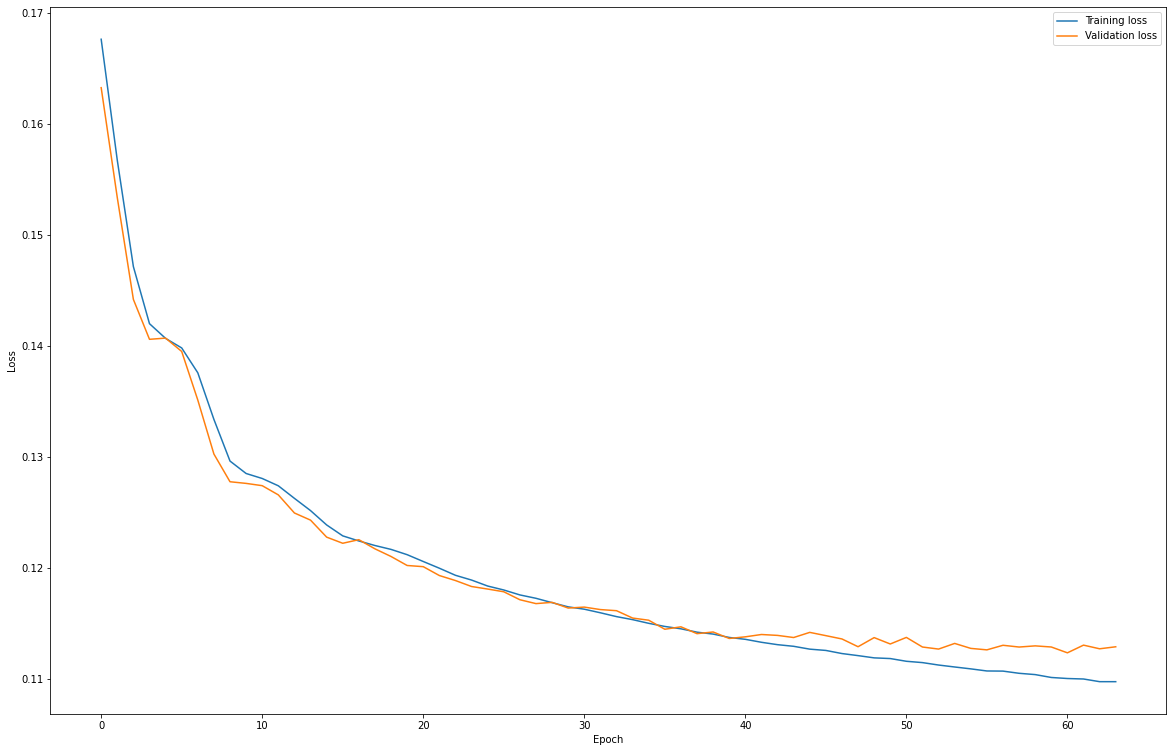

In [ ]:
plt.figure(figsize=(20,13))

plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pickle.dump(embeddings, open(path + "embeddings.p", "wb" ) )

# Clustering

In [ ]:
target = pd.read_csv(path + "train_target.csv")  

In [ ]:
target = pd.read_csv(path + "train_target.csv")  
client_target_dict = pd.Series(target.bins.values, index=target.client_id).to_dict()
age_target = np.vectorize(client_target_dict.get)(train_dataset.clients)


predict_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=SequentialSampler(train_dataset))

pred = np.zeros(shape=(len(train_dataset), SEQUENCES_PER_CLIENT, RNN_HIDDEN_STATE_DIMENSIONS))
client_targets = np.zeros(shape=len(train_dataset))
age_targets = np.zeros(shape=len(train_dataset))

encoder.eval()
for batch_idx, (sequences, labels) in enumerate(predict_dataloader):
    numerical = sequences[:,:,:,np.logical_not(categorical_mask)].to(device)
    categorical = sequences[:,:,:,categorical_mask].to(device)
    labels = labels.numpy()

    with torch.no_grad():
        embeddings = encoder(numerical.float(), categorical.int()).to(device)
    embeddings = embeddings.view(-1, SEQUENCES_PER_CLIENT, RNN_HIDDEN_STATE_DIMENSIONS)

    pred[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE, :, :] = embeddings.cpu().numpy()
    client_targets[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE] = labels
    age_targets[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE] = np.vectorize(client_target_dict.get)(labels)


train_pred = pred.reshape(-1, RNN_HIDDEN_STATE_DIMENSIONS)
train_client_targets = np.repeat(client_targets, SEQUENCES_PER_CLIENT)
train_age_targets = np.repeat(age_targets, SEQUENCES_PER_CLIENT)

In [ ]:
age_target = np.vectorize(client_target_dict.get)(test_dataset.clients)

predict_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=SequentialSampler(test_dataset))

pred = np.zeros(shape=(len(test_dataset), SEQUENCES_PER_CLIENT, RNN_HIDDEN_STATE_DIMENSIONS))
client_targets = np.zeros(shape=len(test_dataset))
age_targets = np.zeros(shape=len(test_dataset))

encoder.eval()
for batch_idx, (sequences, labels) in enumerate(predict_dataloader):
    numerical = sequences[:,:,:,np.logical_not(categorical_mask)].to(device)
    categorical = sequences[:,:,:,categorical_mask].to(device)
    labels = labels.numpy()

    with torch.no_grad():
        embeddings = encoder(numerical.float(), categorical.int()).to(device)
    embeddings = embeddings.view(-1, SEQUENCES_PER_CLIENT, RNN_HIDDEN_STATE_DIMENSIONS)

    pred[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE, :, :] = embeddings.cpu().numpy()
    client_targets[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE] = labels
    age_targets[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE] = np.vectorize(client_target_dict.get)(labels)


test_pred = pred.reshape(-1, RNN_HIDDEN_STATE_DIMENSIONS)
test_client_targets = np.repeat(client_targets, SEQUENCES_PER_CLIENT)
test_age_targets = np.repeat(age_targets, SEQUENCES_PER_CLIENT)

In [ ]:
pred = np.concatenate([train_pred, test_pred])
client_targets = np.concatenate([train_client_targets, test_client_targets])
age_targets = np.concatenate([train_age_targets, test_age_targets])

pickle.dump(pred, open(path + "pred.p", "wb" ) )
pickle.dump(client_targets, open(path + "client_targets.p", "wb" ) )
pickle.dump(age_targets, open(path + "age_targets.p", "wb" ) )

In [ ]:
pred = pickle.load(open(path + "pred.p", "rb" ))
client_targets = pickle.load(open(path + "client_targets.p", "rb" ))
age_targets = pickle.load(open(path + "age_targets.p", "rb" ))

In [ ]:
emb_2d_25 = umap.UMAP(n_neighbors=75, min_dist=0.25).fit_transform(pred)

[]

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


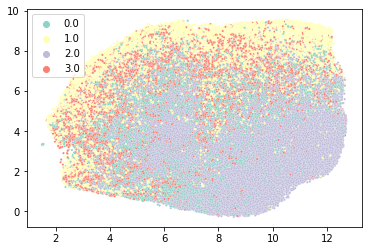

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 20))
# axs[0].set_title('min_distance=0.0')
# sns.scatterplot(ax=axs[0], x=emb_2d_00[:,0], y=emb_2d_00[:,1], hue=age_targets, s=5, palette="Set3")
axs[1].set_title('min_distance=0.25')
sns.scatterplot(ax=axs[1], x=emb_2d_25[:,0], y=emb_2d_25[:,1], hue=age_targets, s=5, palette="Set3")
# axs[2].set_title('min_distance=0.5')
# sns.scatterplot(ax=axs[2], x=emb_2d_50[:,0], y=emb_2d_50[:,1], hue=age_targets, s=5, palette="Set3")

plt.legend()
plt.plot()

[]

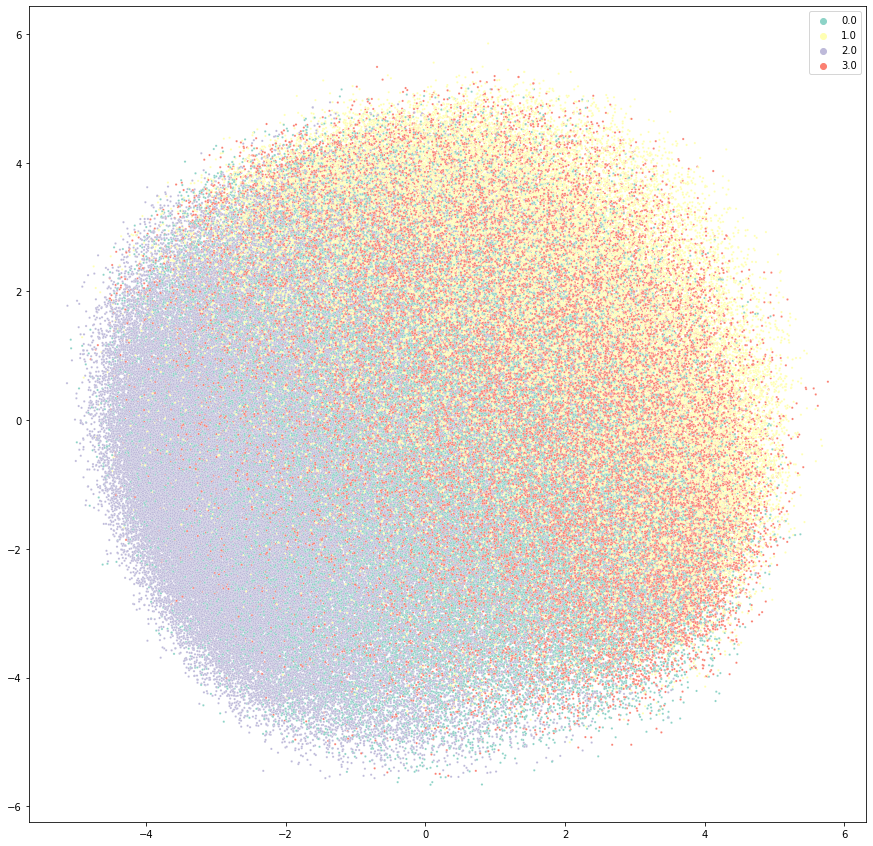

In [ ]:
pca = decomposition.PCA(n_components=2)

pca_data = pca.fit_transform(pred)

plt.figure(figsize=(15,15))
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=age_targets, s=5, palette="Set3")
plt.plot()

In [ ]:
def clustering_accuracy(y_true, y_pred):
    max_acc = 0
    true_pred = np.zeros(len(y_pred))
    for permutation in permutations(range(len(np.unique(y_true)))):
        permutation_dict = {k: v for k, v in enumerate(permutation)}
        accuracy = accuracy_score(y_true, np.vectorize(permutation_dict.get)(y_pred))
        if accuracy > max_acc:
            max_acc = accuracy
            true_pred = np.vectorize(permutation_dict.get)(y_pred)
    return max_acc, true_pred

def visualize_clustering(space, y_true, y_pred, name='unspecified'):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].set_title('Actual targets')
    sns.scatterplot(ax=axs[0], x=space[:,0], y=space[:,1], hue=y_true, s=5, palette="Set3")
    axs[1].set_title('Clustering predictions, ' + name)
    sns.scatterplot(ax=axs[1], x=space[:,0], y=space[:,1], hue=y_pred, s=5, palette="Set3")

In [ ]:
kmeans = KMeans(n_clusters=NUM_OF_CLUSTERS, 
                algorithm='full', 
                tol=1e-3,
                random_state=1001)

kmeans_res = kmeans.fit(pred)

print(clustering_accuracy(age_targets, kmeans_res.labels_))

(0.45307333333333333, array([0, 1, 0, ..., 0, 0, 0], dtype=int32))


Accuracy: 0.45307333333333333


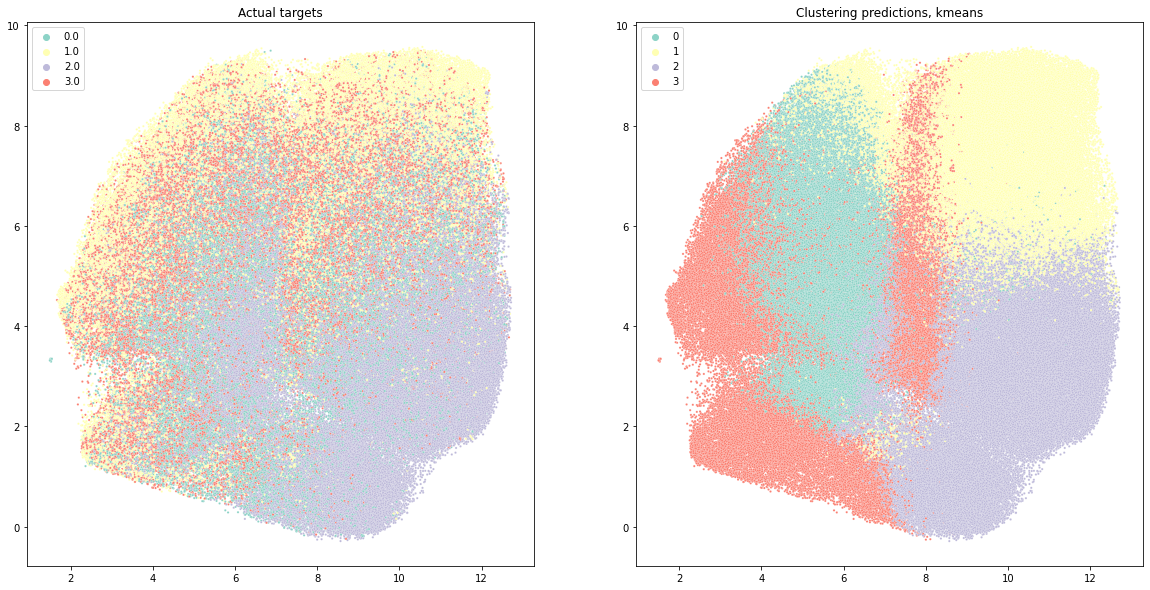

In [ ]:
accuracy, labels = clustering_accuracy(age_targets, kmeans_res.labels_)

print('Accuracy: {}'.format(accuracy))

visualize_clustering(emb_2d_25, age_targets, labels, 'kmeans')

# fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].set_title('Actual targets')
# sns.scatterplot(ax=axs[0], x=emb_2d_25[:,0], y=emb_2d_25[:,1], hue=age_targets, s=5, palette="Set3")
# axs[1].set_title('Clustering predictions, kmeans')
# sns.scatterplot(ax=axs[1], x=emb_2d_25[:,0], y=emb_2d_25[:,1], hue=labels, s=5, palette="Set3")

In [ ]:
# Murders RAM

# spectral = SpectralClustering(n_clusters=NUM_OF_CLUSTERS, 
#                               eigen_solver='arpack', 
#                               affinity='rbf')

# spectral_res = spectral.fit(pred)

# print(clustering_accuracy(age_targets, res.labels_))

In [ ]:
# Colab falls asleep.

# !pip install hdbscan
# import hdbscan

# clusterer = hdbscan.HDBSCAN()
# clusterer.fit(pred)

     |████████████████████████████████| 6.4MB 21.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311661 sha256=1ee28e399b770cca6f3355b3419e9e61d696c2c80d763e55d45f497a8e09558c
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan
